# 运动行为识别小程序开发过程及代码说明

运动行为识别小程序开发过程中经历了HAR运动行为的六轴数据收集，包括模型选择与导出模型，运动行为识别和运动行为个数计算三大部分，下面将详述之。

## HAR运动姿态六轴传感器的数据采集

小程序开发的第一个模块是运动行为数据收集模块，原理是刚进入页面调用陀螺仪和加速度计的start函数，设置参数为"game"，即20ms的采样率，点开始测试后小程序调用加速度计和陀螺仪的on函数，分别收集用户做的四个HIIT动作的六轴数据，每个用户数据收集20s，每个轴共收集到1000个数据点。将所有的数据上传到小程序的云服务器，并导出json文件。这个步骤我发现了第一个问题，就是安卓系统不支持20ms的采样，最多仅支持ui模式了60ms采样。但是我并没有单独为安卓系统的用户开发一个模板，因为即使调用ui模式，安卓采样也是很混乱的。一个好的解决方法是用苹果系统"game"模式的数据来训练模型，这样即使安卓用户使用"ui"模式进行测试效果依然很好。

### 对采集的数据进行预处理和模型选择

先读取json文件里的六轴数据，并对提取到的六轴数据滤波处理，因为原数据是1000个点，为了尽可能多的得到更多的训练集，我们以百分之50的交叉的方式把一个数据分成8个128个点的数据。这样每个训练集的数据都变成了原来的8倍（我这里的点取得是50-1010是因为其实我数据收集是收集了1050个点，因为将前50个点有可能测试者会进行一些准备动作）。进行完数据集的分割之后在进行特征值的提取工作。我从六个轴的每个轴里分别选取了他的最大值，最小值，中位数，均值，标准差和绝对中位差。并将六个轴的特征值合在一起，并且对每个动作表上标签，比如activity1数据集里的动作给标签1，放在36个特征值的最后，变成一个1*37  的向量，作为一个训练数据。这里做出说明：我只提取了时域的特征而没有提取频域的特征是因为如果做完FFT之后，提取特征个数会变成170多个，而只提取时域的特征的准确率就有了百分之90多，即使把频域提取出来准确率增长也是很小的，但是计算量增大会使识别的速度下降）。

In [18]:
import json
from scipy import signal
from scipy import stats
import numpy as np
file1 = open("activity1.json", 'r', encoding='utf-8')
file2 = open("activity2.json", 'r', encoding='utf-8')
file3 = open("activity3.json", 'r', encoding='utf-8')
file4 = open("activity4.json", 'r', encoding='utf-8')
dataset=[]
dataset1 = []
dataset2 = []
dataset3 = []
dataset4 = []
for line in file1.readlines():
    lines= json.loads(line)
    b, a = signal.butter(8, 0.2, 'lowpass')  
    accxData = signal.filtfilt(b, a, lines["accx"])
    accxData=accxData.tolist()
    accyData = signal.filtfilt(b, a, lines["accz"])  
    accyData=accyData.tolist()
    acczData = signal.filtfilt(b, a, lines["accz"])  
    acczData=acczData.tolist()
    gryxData = signal.filtfilt(b, a, lines["gryx"])  
    gryxData = gryxData.tolist()
    gryyData = signal.filtfilt(b, a, lines["gryy"])  
    gryyData = gryyData.tolist()
    gryzData = signal.filtfilt(b, a, lines["gryz"])  
    gryzData = gryzData.tolist()
   # y = acczData
   # x = range(len(y))
    #plt.plot(y)
   # plt.show()
    for i in range(50, 1010, 64):
        xc = accxData[i:i + 128]
        yc = accyData[i:i + 128]
        zc = acczData[i:i + 128]
        xw = gryxData[i:i + 128]
        yw = gryyData[i:i + 128]
        zw = gryzData[i:i + 128]
        ##这里是一个数据的36个特征值，最后一个1表示label
        s=[max(xc),min(xc),np.median(xc),np.mean(xc),np.std(xc),stats.median_absolute_deviation(xc),max(yc),min(yc),np.median(yc),np.mean(yc),np.std(yc),stats.median_absolute_deviation(yc),max(zc),min(zc),np.median(zc),np.mean(zc),np.std(zc),stats.median_absolute_deviation(zc),max(xw),min(xw),np.median(xw),np.mean(xw),np.std(xw),stats.median_absolute_deviation(xw),max(yw),min(yw),np.median(yw),np.mean(yw),np.std(yw),stats.median_absolute_deviation(yw),max(zw),min(zw),np.median(zw),np.mean(zw),np.std(zw),stats.median_absolute_deviation(zw),1]
        dataset1.append(s)
for line in file2.readlines():
    lines= json.loads(line)
    b, a = signal.butter(8, 0.2, 'lowpass') 
    accxData = signal.filtfilt(b, a, lines["accx"]) 
    accxData=accxData.tolist()
    accyData = signal.filtfilt(b, a, lines["accz"])  
    accyData=accyData.tolist()
    acczData = signal.filtfilt(b, a, lines["accz"]) 
    acczData=acczData.tolist()
    gryxData = signal.filtfilt(b, a, lines["gryx"]) 
    gryxData = gryxData.tolist()
    gryyData = signal.filtfilt(b, a, lines["gryy"])  
    gryyData = gryyData.tolist()
    gryzData = signal.filtfilt(b, a, lines["gryz"])  
    gryzData = gryzData.tolist()
    for i in range(50, 1010, 64):
        xc = accxData[i:i + 128]
        yc = accyData[i:i + 128]
        zc = acczData[i:i + 128]
        xw = gryxData[i:i + 128]
        yw = gryyData[i:i + 128]
        zw = gryzData[i:i + 128]
        ##这里是一个数据的36个特征值，最后一个1表示label
        s=[max(xc),min(xc),np.median(xc),np.mean(xc),np.std(xc),stats.median_absolute_deviation(xc),max(yc),min(yc),np.median(yc),np.mean(yc),np.std(yc),stats.median_absolute_deviation(yc),max(zc),min(zc),np.median(zc),np.mean(zc),np.std(zc),stats.median_absolute_deviation(zc),max(xw),min(xw),np.median(xw),np.mean(xw),np.std(xw),stats.median_absolute_deviation(xw),max(yw),min(yw),np.median(yw),np.mean(yw),np.std(yw),stats.median_absolute_deviation(yw),max(zw),min(zw),np.median(zw),np.mean(zw),np.std(zw),stats.median_absolute_deviation(zw),2]
        dataset2.append(s)
for line in file3.readlines():
    lines= json.loads(line)
    b, a = signal.butter(8, 0.2, 'lowpass') 
    accxData = signal.filtfilt(b, a, lines["accx"])  
    accxData=accxData.tolist()
    accyData = signal.filtfilt(b, a, lines["accz"]) 
    accyData=accyData.tolist()
    acczData = signal.filtfilt(b, a, lines["accz"]) 
    acczData=acczData.tolist()
    gryxData = signal.filtfilt(b, a, lines["gryx"])  
    gryxData = gryxData.tolist()
    gryyData = signal.filtfilt(b, a, lines["gryy"])  
    gryyData = gryyData.tolist()
    gryzData = signal.filtfilt(b, a, lines["gryz"]) 
    gryzData = gryzData.tolist()
    for i in range(50, 1010, 64):
        temp=[]
        xc = accxData[i:i + 128]
        yc = accyData[i:i + 128]
        zc = acczData[i:i + 128]
        xw = gryxData[i:i + 128]
        yw = gryyData[i:i + 128]
        zw = gryzData[i:i + 128]
        #print(len(xc))
        ##这里是一个数据的36个特征值，最后一个1表示label
        s=[max(xc),min(xc),np.median(xc),np.mean(xc),np.std(xc),stats.median_absolute_deviation(xc),max(yc),min(yc),np.median(yc),np.mean(yc),np.std(yc),stats.median_absolute_deviation(yc),max(zc),min(zc),np.median(zc),np.mean(zc),np.std(zc),stats.median_absolute_deviation(zc),max(xw),min(xw),np.median(xw),np.mean(xw),np.std(xw),stats.median_absolute_deviation(xw),max(yw),min(yw),np.median(yw),np.mean(yw),np.std(yw),stats.median_absolute_deviation(yw),max(zw),min(zw),np.median(zw),np.mean(zw),np.std(zw),stats.median_absolute_deviation(zw),3]
        dataset3.append(s)
for line in file4.readlines():
    lines= json.loads(line)
    b, a = signal.butter(8, 0.2, 'lowpass') 
    accxData = signal.filtfilt(b, a, lines["accx"])  
    accxData=accxData.tolist()
    accyData = signal.filtfilt(b, a, lines["accz"]) 
    accyData=accyData.tolist()
    acczData = signal.filtfilt(b, a, lines["accz"])  
    acczData=acczData.tolist()
    gryxData = signal.filtfilt(b, a, lines["gryx"])  
    gryxData = gryxData.tolist()
    gryyData = signal.filtfilt(b, a, lines["gryy"]) 
    gryyData = gryyData.tolist()
    gryzData = signal.filtfilt(b, a, lines["gryz"])  
    gryzData = gryzData.tolist()

    for i in range(50, 1010, 64):
        temp=[]
        xc = accxData[i:i + 128]
        yc = accyData[i:i + 128]
        zc = acczData[i:i + 128]
        xw = gryxData[i:i + 128]
        yw = gryyData[i:i + 128]
        zw = gryzData[i:i + 128]
        #print(len(xc))
        ##这里是一个数据的36个特征值，最后一个1表示label
        s=[max(xc),min(xc),np.median(xc),np.mean(xc),np.std(xc),stats.median_absolute_deviation(xc),max(yc),min(yc),np.median(yc),np.mean(yc),np.std(yc),stats.median_absolute_deviation(yc),max(zc),min(zc),np.median(zc),np.mean(zc),np.std(zc),stats.median_absolute_deviation(zc),max(xw),min(xw),np.median(xw),np.mean(xw),np.std(xw),stats.median_absolute_deviation(xw),max(yw),min(yw),np.median(yw),np.mean(yw),np.std(yw),stats.median_absolute_deviation(yw),max(zw),min(zw),np.median(zw),np.mean(zw),np.std(zw),stats.median_absolute_deviation(zw),4]
        dataset4.append(s)

现在我已经将所有的数据都进行了特征提取，下一步需要将四个数据集合在一起，首先需要将他转成numpy 的数组，在调用numpy数组合在一起的语句变成一个大的数据集，然后调用train_test_split分出训练集和测试集。

In [23]:
from sklearn.model_selection import train_test_split#将数据分为测试集和训练集
import random
from sklearn.metrics import accuracy_score
dataset1=  np.array(dataset1)
dataset2 = np.array(dataset2)
dataset3 = np.array(dataset3)
dataset4 = np.array(dataset4)
random.seed(1)
dataset=np.vstack((dataset1,dataset2,dataset3,dataset4))
y_data=dataset[:,-1]
x_data=np.delete(dataset,-1,axis=1)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data,test_size=0.3)  # 利用train_test_split进行将训练集和测试集进行分开，test_size占30%

数据已经处理好了，下面就是模型选择的问题，这里我比较了KNN和随机森林两个模型，最终选取随机森林作为HIIT算法模型

In [24]:
from sklearn.neighbors import KNeighborsClassifier#利用邻近点方式训练数据
num=0
knn = KNeighborsClassifier()  # 训练模型为KNN
knn.fit(X_train, y_train)  # 进行填充测试数据进行训练
x_predit=knn.predict(X_test)
print('KNN结果：', accuracy_score(y_test, x_predit))

KNN结果： 0.9518518518518518


In [25]:
from sklearn.linear_model import LogisticRegression #这里使用的是LR模型
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
x_predit=lr_clf.predict(X_test)
print('LR结果：', accuracy_score(y_test, x_predit))

LR结果： 0.825925925925926


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [30]:
from sklearn import svm

svm = svm.SVC(gamma=0.001, C=100.)
svm.fit(X_train, y_train)
x_predit=svm.predict(X_test)
print('SVM结果：', accuracy_score(y_test, x_predit))

SVM结果： 0.8870370370370371


In [26]:
from  sklearn.ensemble.forest  import RandomForestClassifier
rfc = RandomForestClassifier()  # 训练模型为随机森林
rfc = rfc.fit(X_train, y_train)  # 用训练集数据训练模型
x_predit=rfc.predict(X_test)
print('RFC结果：', accuracy_score(y_test, x_predit))

RFC结果： 0.9481481481481482


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


其实可以看到，随机森林的准确率约等于KNN的准确率，高于SVM和LR，所以随机森林和KNN是可以考虑的两个算法。但是实际部署的时候，我们不仅需要理论上的准确率，还需要再识别的时候可以尽快的识别，减少服务器计算的时间，考虑使用KNN的话，每次给服务器传送一条数据，就需要大量的计算，而使用随机森林的话是可以使用原来就构建好的树，减少计算时间，用户体验感较好。

在这里我又重新训练了一下随机森林的模型，并导出一个pkl文件。因为模型选择的时候进行了一定的数据分割，有百分之30的数据作为验证集，一定程度上减少了训练集。

In [31]:
from sklearn.externals import joblib
rfc = RandomForestClassifier()  
rfc = rfc.fit(x_data, y_data)  
joblib.dump(rfc, "./rfc.pkl")  # rfc是训练好的模型， "./rfc.pkl"是模型要保存的路径及保存模型的文件名，其中，'pkl' 是sklearn中默认的保存格式gai

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


['./rfc.pkl']

至此，小程序开发的第一个模块数据收集及模型训练就已经完成了，下面我们需要进行运动行为识别模块开发

## 行为识别部分

### 小程序端的发送与接收

与收集数据的小程序不同，我并没有在刚进去就调用六轴的start函数，而是在点开始的时候调用start和on函数，而且在页面卸载的时候会调用两个stop函数，原因是我发现如果多次调试会出现两个加速度计和两个陀螺仪同时运行关不掉的情况，这样给云服务器发送的数据就会有很多的重复。我用setInterval函数设置了一个2000ms的循环，调用wx.request函数每隔两秒给服务器发送一次六轴收集的数据，并得到反馈后清空六轴数组，这样每次都给云服务器发送6个100列的列表，再根据云服务器返回的值进行语音播报并setData到页面上。同时设置了一个30s的定时器，到时间会自动关闭加速度计和陀螺仪，并终止循环计。

### 云端的部署

在训练出来随机森林的实例之后，在云服务器上调用rz语句将他上传到云服务器，然后就可以在云服务器上进行行为识别。与在本地的方法类似，进行完数据读取之后进行滤波和时域特征值提取，特别注意的是，实例仅接受-1到1的数据，所以需要调用reshape语句将其转成（-1，1）的值。在云服务器上计算出属于哪一类之后，用1代表徒手侧平举动作，2代表前后交叉小跑动作，3代表开合跳动作，4代表半蹲动作，转换成字符串的形式发送给小程序。

In [33]:
from flask import Flask,request
import json
import joblib
import numpy as np
from scipy import signal
from scipy import stats
app = Flask(__name__)

@app.route('/',methods=['post'])
def getdata():
    data = request.get_json()
    accX=data["accXs"]
    accY=data["accYs"]
    accZ=data["accZs"]
    gyrX=data["gyrXs"]
    gyrY=data["gyrYs"]
    gyrZ=data["gyrZs"]
    b, a = signal.butter(8, 0.2, 'lowpass')  
    xc = signal.filtfilt(b, a, accX)  
    xc=xc.tolist()
    yc = signal.filtfilt(b, a, accY) 
    yc=yc.tolist()
    zc= signal.filtfilt(b, a, accZ)  
    zc=zc.tolist()
    xw = signal.filtfilt(b, a, gyrX)  
    xw=xw.tolist()
    yw = signal.filtfilt(b, a, gyrY) 
    yw=yw.tolist()
    zw = signal.filtfilt(b, a, gyrZ)  
    zw=zw.tolist()
    s=[max(xc),min(xc),np.median(xc),np.mean(xc),np.std(xc),stats.median_absolute_deviation(xc),max(yc),min(yc),np.median(yc),np.mean(yc),np.std(yc),stats.median_absolute_deviation(yc),max(zc),min(zc),np.median(zc),np.mean(zc),np.std(zc),stats.median_absolute_deviation(zc),max(xw),min(xw),np.median(xw),np.mean(xw),np.std(xw),stats.median_absolute_deviation(xw),max(yw),min(yw),np.median(yw),np.mean(yw),np.std(yw),stats.median_absolute_deviation(yw),max(zw),min(zw),np.median(zw),np.mean(zw),np.std(zw),stats.median_absolute_deviation(zw)]
    s=np.array(s).reshape(1,-1)
    s=s.tolist()
    rfc = joblib.load("./rfc.pkl")
    y_read = rfc.predict(s)
    return str(y_read)

## 运动个数计数部分

在正式讲解小程序端和云端的实现方式之前，我先在本地的pycharm上进行了识别方法的探索，比较好的办法是选取accY轴的数据，然后对他进行波峰检测。从下面代码运行的结果和画出的图可以看待，使用2阶带通滤波器和寻峰函数对个数的计算是十分准确的。这样的寻峰方法是把20s的数据放在一起去看波峰，那如果分割成许多的小部分，然后看每个小部分的波峰结果怎样呢？我实践之后发现效果很差，根据所有波峰加和的个数可能达到了原有个数的两倍。这就给我在小程序端部署提供了思路。

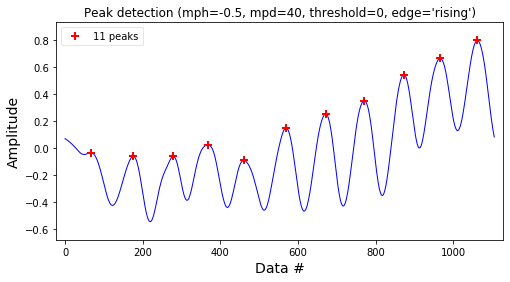

the true number is 13.0and  I use accy got  11


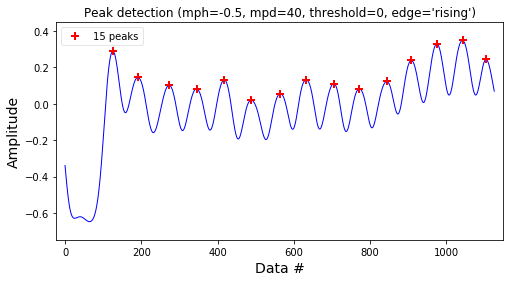

the true number is 17.0and  I use accy got  15


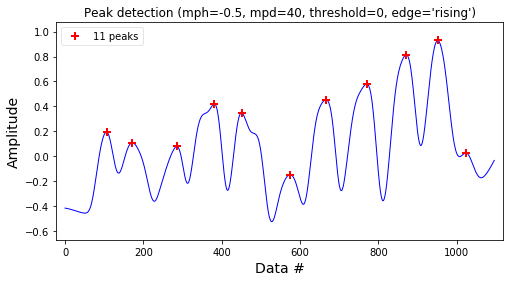

the true number is 10.0and  I use accy got  11


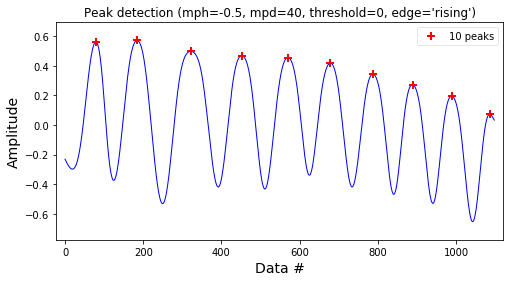

the true number is 10.0and  I use accy got  10


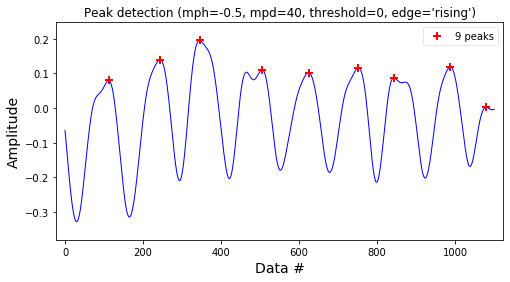

the true number is 10.0and  I use accy got  9


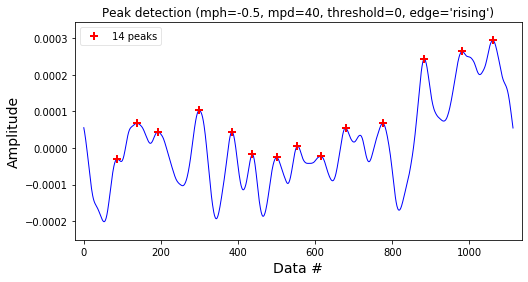

the true number is 14.0and  I use accy got  14


In [44]:
from detecta import detect_peaks
from scipy import signal
from matplotlib import pyplot as plt
if __name__ == '__main__':
    file1 = open("activity1.json", 'r', encoding='utf-8')
    num=0
    for line in file1.readlines():

        lines= json.loads(line)
        b, a = signal.butter(2, [0.001,0.03], 'bandpass') # 配置2阶带通滤波器
        accyData = signal.filtfilt(b, a, lines["accy"])  
        accyData=accyData.tolist()
        s1=detect_peaks(accyData, mph=-0.5,mpd=40,show=True)
        a=lines["number"]
        print("the true number is " + str(a) + "and  I use accy got  " + str(len(s1)))
        num+=1
        if(num>5):
            break

### 小程序端

前文提到小程序已经具有行为识别的功能，在每次识别之后都会得到服务器发回来的一个返回值。在这步骤之后我进行了改进，一方面不马上情况六轴的数据，而是定义一个全局变量allYs这样一个数组，把每次发送用到的accys数据都填充进去，相当于在最后30s的时候我获得了一个拼接好的六轴数据，另一方面，对于从小程序获得的返回值，定义一个数组名为Array，把每次得到的返回值都存进去。到了定时器60s的最后，我们再次向云服务器的另一个端口发送数据，将完全拼接的allYs和Array这两个数组发给服务器。并等待服务器发送回来一个4行的列表。每一行代表一个动作的个数，并把这个值setData到页面上。

### 云服务器端

云服务器接收到这两个数组以后，对allYs进行带通滤波，然后看峰值所在的区间，比如我们给云服务器发送了15次数据，那就是15个区间，把每个区间的峰值个数求出来，然后对应的看每个区间是Array里的什么动作，给相应的动作加上峰值个数，最后返回一个四行的列表。

In [45]:
@app.route('/123',methods=['post'])
def num():
        datas=request.get_json()
        allY=datas["allYs"]
        array=datas["array"]
        print(len(allY))
        c=len(allY)/15
        temps=[]
        alls=[0,0,0,0]
        d=0
        print(array)
        b1, a1 = signal.butter(2, [0.001,0.03], 'bandpass')
        allYs = signal.filtfilt(b1, a1, allY)
        peak=detect_peaks(allYs, mph=-0.5,mpd=40,show=True)
        print(peak)
        print("the number of peak is"+str(len(peak)))
        for num in peak:
            temps.append(int(num/c))
        print("识别的结果所在的区间是"+str(temps))
        resdata = []
        for i in range(0,15):
            resdata.append(temps.count(i))
        print("各个区间的个数为"+str(resdata))
        for i in range(0,15):

            d=int(array[i])-1
            alls[d]=resdata[i]+alls[d]
        return str(alls)



至此，运动行为识别小程序已经开发完了，具有数据收集，行为预测和个数计算三大功能，现在已经上线，欢迎大家体验并对其中出现的问题给予指正。